In [1]:
import scipy as sc
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl

In [2]:
# BACKGROUND - define useful functions

# gives X(z) as defined in (8) Wang and Mota (note - k vanishes when calculating X)

def X(z, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + alpha_tilde
    
    if alpha_tilde == 0:
        return 1
    else:
        return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + Omega_r * (1 + z)** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)

# gives E(z) = H(z) / H0

def E(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + alpha_tilde
    

    if alpha_tilde == 0.0:
        ans = np.sqrt(Omega_m * (1 + z) ** 3 + Omega_r * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)
    else:
        
        ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1)/(2 * alpha_tilde))
    
    return ans

# gives dE/dz

def dEdz(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    
    # Wang and Mota
    dEdz = ((3 * Omega_m * (1 + z) ** 2) + (4 * Omega_r * (1 + z) ** 3) + (2 * Omega_k * (1 + z)))/(2 * E(z , cosmo) * np.sqrt(X(z , cosmo)))
    
    return dEdz

# gives dE/dx, x = lna

def dEdx(z , cosmo):
    
    dEdx = -dEdz(z , cosmo) * (1 + z)
    
    return dEdx

In [3]:
# PERTURBATIONS - define useful functions

# ---- finding f ------
#returns derivative of f with respect to x, where x = ln(a)
def dfdx(f , x , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    
    z = np.exp(-x) - 1
    dfdx = -f ** 2 - (2 + dEdx(z , cosmo)/E(z , cosmo)) * f + (3/2) * Omega_m * (1+z)**3 *\
    (1 + 2 * alpha_tilde * E(z , cosmo) * (2*dEdx(z , cosmo) - E(z , cosmo)))/((2 * alpha_tilde * E(z , cosmo) ** 2 + 1)**2\
                                                                               * E(z , cosmo) ** 2)
    return dfdx

# ---TEST: finding f in lambdaCDM only ----
def dfdxLCDM(f , x , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    
    z = np.exp(-x) - 1
    
    dfdx = -f**2 - (2 + dEdx(z , cosmo)/E(z , cosmo)) * f + 3*Omega_m*(1+z)**3/(2*E(z , cosmo)**2)
    
    return dfdx

# ---- finding sigma8 ------
# returns second derivative of sigma8 (equivalent to delta_m up to boundary conditions) with respect to x
def ddsigma8ddx (sigma8 , dsigma8dx , x , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    z = np.exp(-x) - 1

    Eval = E(z , cosmo)
    dEvaldx = dEdx(z , cosmo)
    
    ddsigma8ddx = -(2 + dEvaldx/Eval)*dsigma8dx + (3/2)*Omega_m*(1+z)**3 *sigma8*(1 + 2 * alpha_tilde * Eval * (2*dEvaldx - Eval))/\
    ((2 * alpha_tilde * Eval ** 2 + 1)**2 * Eval ** 2)
    return ddsigma8ddx


def coupled_sigma8_dsigma8dx(y , x , cosmo):
    sigma8 , dsigma8dx = y
    ydot = [dsigma8dx, ddsigma8ddx(sigma8 , dsigma8dx , x , cosmo)]
    return ydot

In [4]:
# Define constants

cosmo = [0.4, 0.045 , 0 , 9.2e-5 , 0]                      #  Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde 
cosmoLCDM = ccl.core.Cosmology(Omega_c=cosmo[0],
                               Omega_b=cosmo[1], 
                               sigma8=0.81,
                               h = 0.67,
                               n_s=0.96,
                               Omega_k=cosmo[2], 
                               Omega_g=cosmo[3])
                   
# create coord times
p = 3
x = np.linspace(0, -3, int(10**p))
a = np.exp(x)
z = 1/a - 1
# create boundary condition for f: value of f at x = -2
BC = (cosmo[0]  + cosmo[1]) ** 0.55

#find solution
f = odeint(dfdxLCDM, BC, x, args=(cosmo,), mxstep=int(1e4))
f = np.transpose(f)[0]

print(f[0] - ccl.growth_rate(cosmoLCDM,1))

0.0008503485615897199


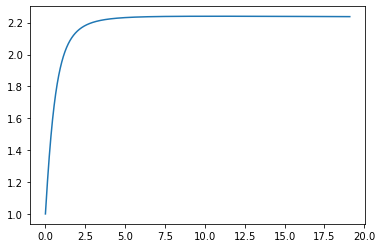

In [5]:
plt.plot(z,(1+z)**3/(E(z , cosmo)**2))

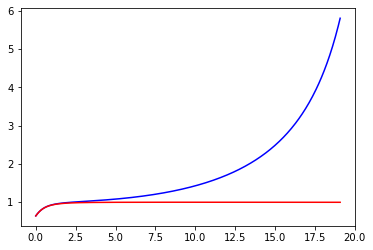

In [6]:
plt.plot(z,f, color = "b")
plt.plot(z, ccl.growth_rate(cosmoLCDM,a), color = "r")
#plt.plot(np.exp(x),f - ccl.growth_rate(cosmoLCDM,np.exp(x)))

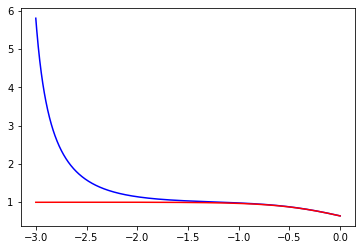

In [7]:
plt.plot(x,f, color = "b")
plt.plot(x, ccl.growth_rate(cosmoLCDM,a), color = "r")

In [8]:
# create boundary condition for sigma8
BCs = [0.78,0.78]


#find solution
soln = odeint(coupled_sigma8_dsigma8dx, BCs, x, args=(cosmo,), mxstep=int(1e4))

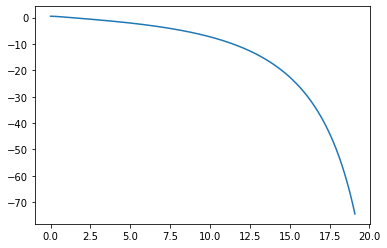

In [9]:
sigma8 = soln[:,0]

plt.plot(np.exp(-x) - 1,sigma8*f)

